# Reading in Data


In [38]:
import os
import rasterio
import geopandas as gpd

from rasterio.plot import show

# Test dir
img_dir = '../../data/raw/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/'

## Read Shapefile

In [39]:
train_fp = '../../data/raw/train/train.shp'
train_df = gpd.read_file(train_fp)

# Drop NaNs
train_df = train_df.loc[~train_df.geometry.isna()]
train_df.reset_index(drop=True, inplace=True)


train_df.head()

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,POLYGON ((2467881.175041331 -3352032.059296422...
1,2,2.064410,3,6,"POLYGON ((2468428.90623293 -3351993.17305059, ..."
2,3,1.080300,3,8,POLYGON ((2468333.745293362 -3352058.485056543...
3,4,1.316190,3,8,POLYGON ((2468607.857733211 -3352012.337531495...
4,7,5.529220,3,8,"POLYGON ((2468646.08520868 -3351706.201920062,..."


### Convert shapefile to coordinate system of raster

In [40]:
train_df = train_df.to_crs({'init': 'epsg:32734'})

## Get Polygon Masks From Raster

In [41]:
!ls $img_dir

T34JEP_20170101T082332_B01.jp2 T34JEP_20170101T082332_B08.jp2
T34JEP_20170101T082332_B02.jp2 T34JEP_20170101T082332_B09.jp2
T34JEP_20170101T082332_B03.jp2 T34JEP_20170101T082332_B10.jp2
T34JEP_20170101T082332_B04.jp2 T34JEP_20170101T082332_B11.jp2
T34JEP_20170101T082332_B05.jp2 T34JEP_20170101T082332_B12.jp2
T34JEP_20170101T082332_B06.jp2 T34JEP_20170101T082332_B8A.jp2
T34JEP_20170101T082332_B07.jp2 T34JEP_20170101T082332_TCI.jp2


In [42]:
import os
import rasterio
from rasterio.plot import show
from glob import glob

from rasterio import mask

def get_shape(geom, raster):
    if geom is None:
        return 0.
    try:
        out_image, out_transform=mask.mask(raster, [geom], crop=True)
    except ValueError:
        return 0.
    return out_image

In [43]:
fp = os.path.join(img_dir,'T34JEP_20170101T082332_B04.jp2')

with rasterio.open(fp) as raster:
    masks = [get_shape(g, raster) for g in train_df.geometry]

### Show largest farm image

/Users/renier.botha/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


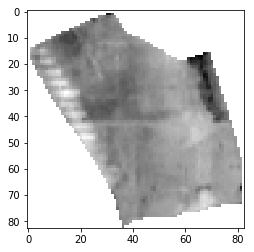

In [44]:
import numpy as np
import matplotlib.pyplot as plt

mask_shapes = [np.size(m) for m in masks]

max_idx = np.argmax(mask_shapes)

largest_farm = masks[max_idx]

plt.imshow(np.log10(largest_farm[0]), cmap='gray')

### Reduce image to summary stats

In [45]:
def calc_img_stats(img: np.array):
    
    assert img.shape[0] == 1, 'Multi-band data might cause kak'
    
    img_flat = img.flatten()
    
    return img_flat.size, img_flat.mean(), img_flat.std()

calc_img_stats(largest_farm)

(6889, 1057.83205109595, 893.9794120902736)